In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import seaborn as sns 
from pandas_profiling import ProfileReport
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import plotly.express as px
from statsmodels.tools import add_constant
import statsmodels.formula.api as smf
from statsmodels.api import Logit

In [2]:
billets=pd.read_csv(r"C:\Users\piard\OneDrive\Documents\P10_ardito_pierre\billets.csv",sep=";")

In [3]:
(billets.isna().sum()/billets.shape[0]).sort_values(ascending=True)

NumExpr defaulting to 8 threads.


is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_up       0.000000
length          0.000000
margin_low      0.024667
dtype: float64

# Imputations des valeurs manquantes à l'aide d'une régression linéaire

## Corrélations entre les variables

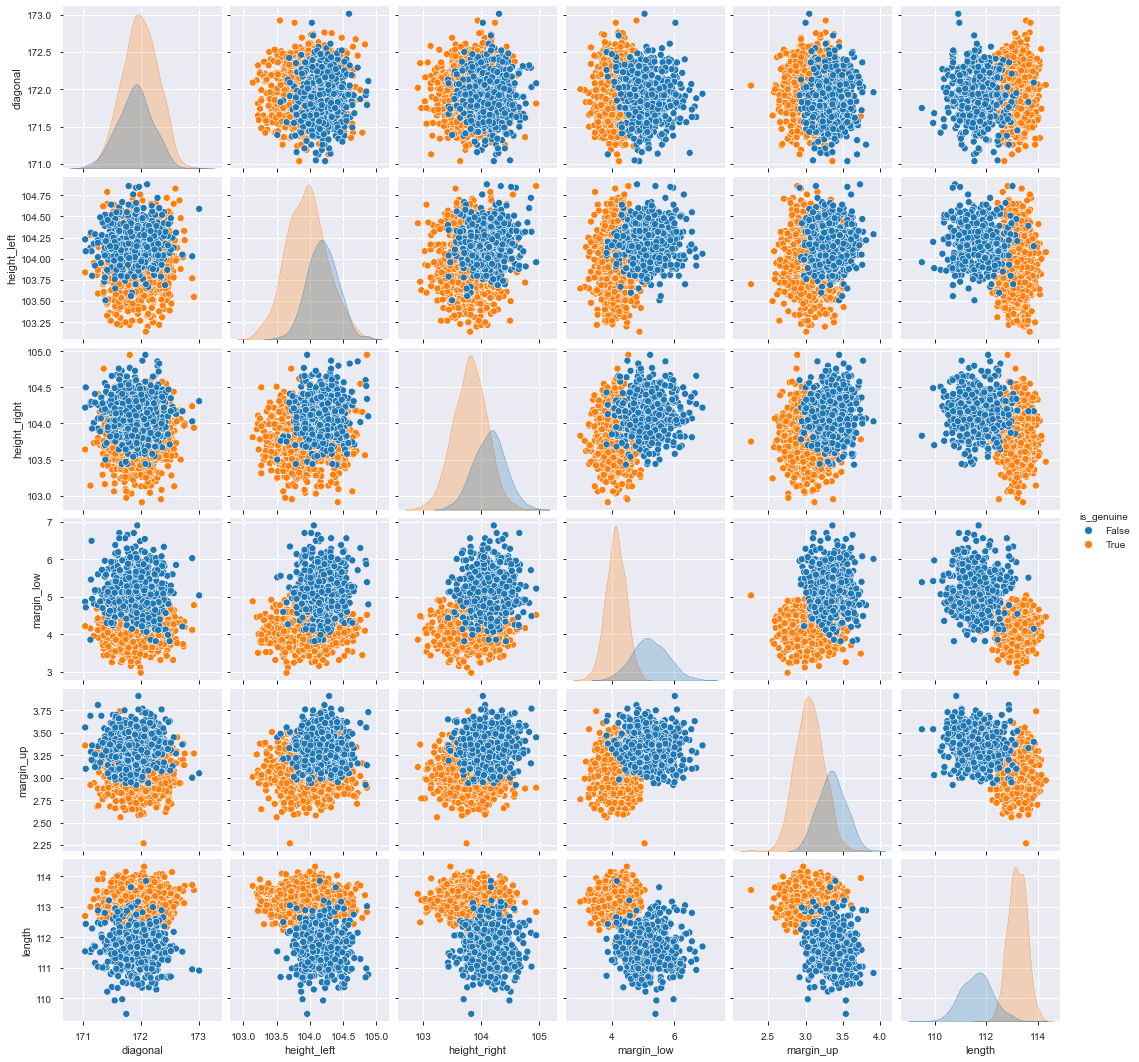

In [4]:
sns.pairplot(billets.dropna(inplace=False),hue='is_genuine')
plt.show()

In [5]:
coor_billets=billets.dropna(inplace=False)
coor_billets.corr()

is_genuine  diagonal  height_left  height_right  margin_low  \
is_genuine      1.000000  0.134720    -0.373624     -0.487177   -0.783032   
diagonal        0.134720  1.000000     0.018265     -0.019428   -0.111534   
height_left    -0.373624  0.018265     1.000000      0.235132    0.302643   
height_right   -0.487177 -0.019428     0.235132      1.000000    0.391085   
margin_low     -0.783032 -0.111534     0.302643      0.391085    1.000000   
margin_up      -0.610412 -0.059147     0.243812      0.306867    0.431606   
length          0.850223  0.100758    -0.314344     -0.404272   -0.666753   

              margin_up    length  
is_genuine    -0.610412  0.850223  
diagonal      -0.059147  0.100758  
height_left    0.243812 -0.314344  
height_right   0.306867 -0.404272  
margin_low     0.431606 -0.666753  
margin_up      1.000000 -0.521139  
length        -0.521139  1.000000

In [6]:
def correlation_matrix(df):
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    sns.heatmap(df.corr(), mask=mask, center=0, cmap='RdBu', 
                linewidths=1, annot=True, fmt=".2f", vmin=-1, vmax=1)
    plt.title('Carte des corrélations', fontsize = 15, fontweight='bold')
    plt.show()

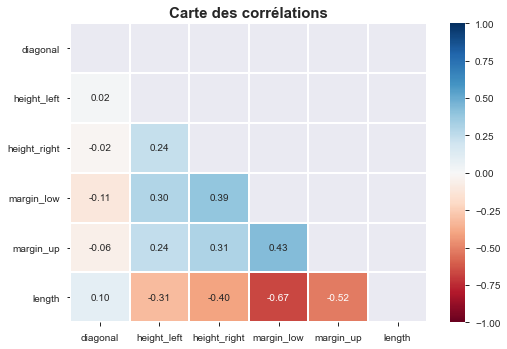

In [7]:
correlation_matrix(coor_billets.iloc[:,1:7])

Les deux variables les plus corrélées sont length et margin_low (négativement).

## Régression linéaire multiple

In [8]:
X = coor_billets[['diagonal',
                  'height_left' ,
                  'height_right',
                  'margin_up',
                  'length'
                 ]]

X_sm =  sm.add_constant(X)
y = coor_billets['margin_low']

model = sm.OLS(y, X_sm)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Mon, 14 Mar 2022   Prob (F-statistic):          2.60e-202
Time:                        11:29:08   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382   

On constate ici que tous les paramètres  sont  significatifs , car leur p-valeur est inférieure à 5 %, le niveau de test que nous souhaitons.

Le 𝑅² vaut environ 0.48, et le 𝑅² ajusté est d'environ 0.48.

Cette valeur est plus élevée qu'en régression linéaire simple, et c'est logique, car lorsque l'on rajoute des variables explicatives potentielles, on accroît naturellement la valeur de ces 𝑅².

Nous allons ici réaliser les tests à un niveau 𝛼=5% :

Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [9]:
alpha=0.05

In [10]:
n=coor_billets.shape[0]
p=6

Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé  analyses.

In [11]:
coor_billets.shape

(1463, 7)

## Calcul des leviers
On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [12]:
analyses = pd.DataFrame({'obs':np.arange(1,n+1)},index=coor_billets.index.tolist())

In [13]:
analyses['levier'] = results.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

In [14]:
analyses

obs    levier
0        1  0.016606
1        2  0.006015
2        3  0.008298
3        4  0.004467
4        5  0.005558
...    ...       ...
1495  1459  0.004307
1496  1460  0.005672
1497  1461  0.001643
1498  1462  0.002254
1499  1463  0.003324

[1463 rows x 2 columns]

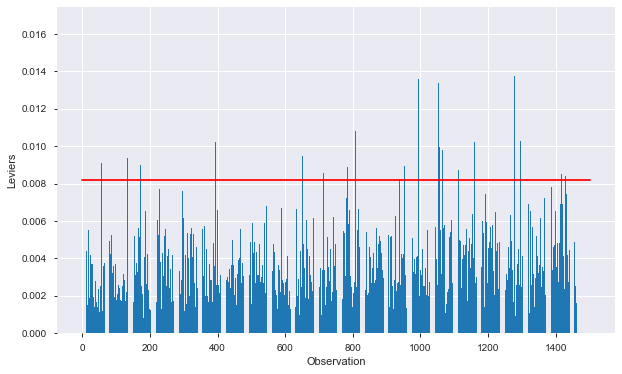

In [15]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='r')
plt.show()

Pour sélectionner les points pour lesquels le levier est supérieur au seuil, on exécute la ligne suivante :

In [16]:
analyses.loc[analyses['levier'] > seuil_levier, :]

obs    levier
0        1  0.016606
2        3  0.008298
34      35  0.009156
52      53  0.013635
56      57  0.009087
...    ...       ...
1453  1417  0.008521
1454  1418  0.008870
1465  1429  0.008390
1478  1442  0.009325
1484  1448  0.008931

[75 rows x 2 columns]

In [17]:
analyses.loc[analyses['levier'] > seuil_levier, :].shape[0]

75

## Calcul des résidus studentisés

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [18]:
analyses['rstudent'] = results.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

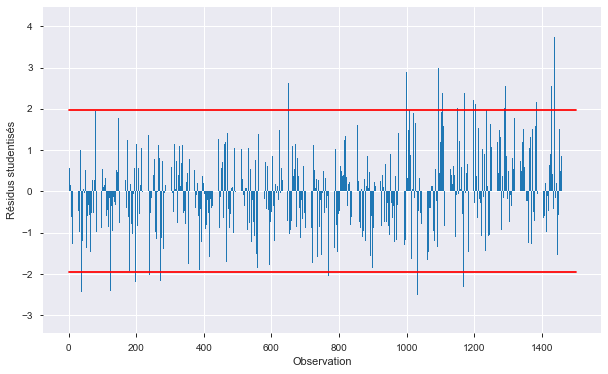

In [19]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

## Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [20]:
influence = results.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p. 

In [21]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

On peut détecter les observations influentes comme ceci :

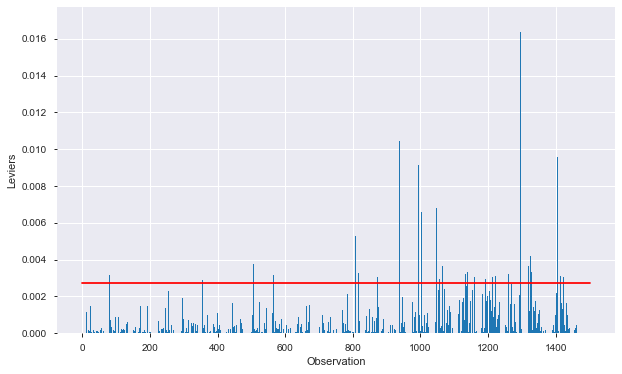

In [22]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.

## Vérifier la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [23]:
variables = results.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.013612899068629,
 1.1382605736082496,
 1.2301145155560393,
 1.4044037781843612,
 1.5769501453665835]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

## Test de l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [24]:
_, pval, __, f_pval = sm.stats.diagnostic.het_breuschpagan(results.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216219784e-16


La p-valeur est inférieure à $5$%, on  rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

## Test de la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [25]:
shapiro(results.resid)

ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)

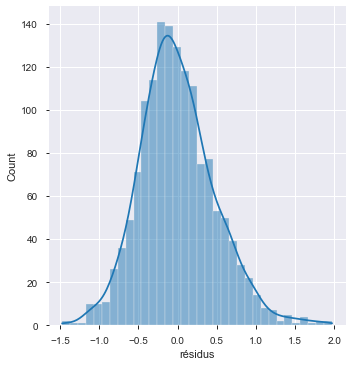

In [26]:
sns.displot(results.resid,kind='hist',kde=True)
plt.xlabel("résidus")
plt.show()

Ici, l'hypothèse de normalité est remise en cause (p-value < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

## Imputations

In [27]:
X_sm

const  diagonal  height_left  height_right  margin_up  length
0       1.0    171.81       104.86        104.95       2.89  112.83
1       1.0    171.46       103.36        103.66       2.99  113.09
2       1.0    172.69       104.48        103.50       2.94  113.16
3       1.0    171.36       103.91        103.94       3.01  113.51
4       1.0    171.73       104.28        103.46       3.48  112.54
...     ...       ...          ...           ...        ...     ...
1495    1.0    171.75       104.38        104.17       3.09  111.28
1496    1.0    172.19       104.63        104.44       3.37  110.97
1497    1.0    171.80       104.01        104.12       3.36  111.95
1498    1.0    172.06       104.28        104.06       3.46  112.25
1499    1.0    171.47       104.15        103.82       3.37  112.07

[1463 rows x 6 columns]

In [28]:
data_billets=billets[billets['margin_low'].isna()]

In [29]:
Y=data_billets[['diagonal','height_left' ,'height_right','margin_up','length']]

In [30]:
Y_sm=sm.add_constant(Y)

In [31]:
vm=results.predict(Y_sm)

In [32]:
vm

72      4.318525
99      4.393668
151     4.410457
197     4.319014
241     4.650617
251     3.803308
284     4.179736
334     4.127442
410     4.135034
413     4.160539
445     4.177420
481     3.768554
505     4.058764
611     4.298047
654     4.160607
675     4.094065
710     4.439846
739     4.470650
742     4.341643
780     4.080414
798     3.614306
844     4.371811
845     4.093621
871     4.249629
895     3.893748
919     3.746333
945     4.237415
946     4.710533
981     4.137780
1076    5.050277
1121    4.802145
1176    5.067584
1303    5.047570
1315    4.778967
1347    5.726993
1435    5.185862
1438    5.140043
dtype: float64

In [33]:
liste=billets[billets['margin_low'].isna()].index.tolist()

In [34]:
maliste2=pd.DataFrame(vm,index=liste,columns=['liste2'])

In [35]:
billets['margin_low'].update(maliste2.liste2)

In [36]:
billets.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [37]:
billets[['is_genuine']]=billets[['is_genuine']].astype('int')

In [38]:
billets.iloc[:,1:7]

diagonal  height_left  height_right  margin_low  margin_up  length
0       171.81       104.86        104.95        4.52       2.89  112.83
1       171.46       103.36        103.66        3.77       2.99  113.09
2       172.69       104.48        103.50        4.40       2.94  113.16
3       171.36       103.91        103.94        3.62       3.01  113.51
4       171.73       104.28        103.46        4.04       3.48  112.54
...        ...          ...           ...         ...        ...     ...
1495    171.75       104.38        104.17        4.42       3.09  111.28
1496    172.19       104.63        104.44        5.27       3.37  110.97
1497    171.80       104.01        104.12        5.51       3.36  111.95
1498    172.06       104.28        104.06        5.17       3.46  112.25
1499    171.47       104.15        103.82        4.63       3.37  112.07

[1500 rows x 6 columns]

In [39]:
print(billets.describe())

        is_genuine     diagonal  height_left  height_right   margin_low  \
count  1500.000000  1500.000000  1500.000000   1500.000000  1500.000000   
mean      0.666667   171.958440   104.029533    103.920307     4.483475   
std       0.471562     0.305195     0.299462      0.325627     0.659632   
min       0.000000   171.040000   103.140000    102.820000     2.980000   
25%       0.000000   171.750000   103.820000    103.710000     4.020000   
50%       1.000000   171.960000   104.040000    103.920000     4.310000   
75%       1.000000   172.170000   104.230000    104.150000     4.870000   
max       1.000000   173.010000   104.880000    104.950000     6.900000   

         margin_up      length  
count  1500.000000  1500.00000  
mean      3.151473   112.67850  
std       0.231813     0.87273  
min       2.270000   109.49000  
25%       2.990000   112.03000  
50%       3.140000   112.96000  
75%       3.310000   113.34000  
max       3.910000   114.44000  


# Analyse univariée

In [40]:
def box(X):
    modalites = billets['is_genuine'].unique()
    groupes = []

    for m in modalites:
      groupes.append(billets[billets['is_genuine']==m][X])

    
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
    plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.xlabel(X,fontsize=15)
    plt.ylabel("Vrai/Faux billets",fontsize=15)
    plt.show()
    

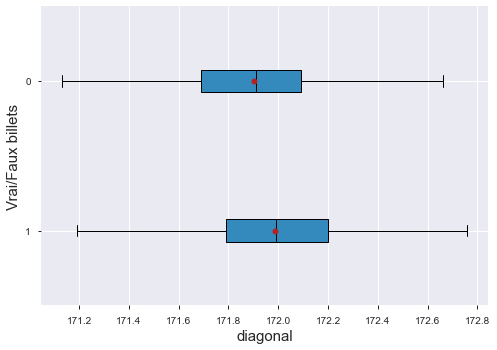

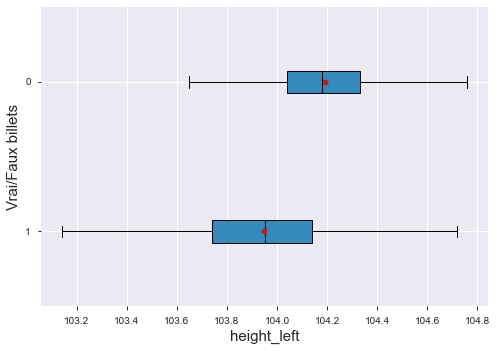

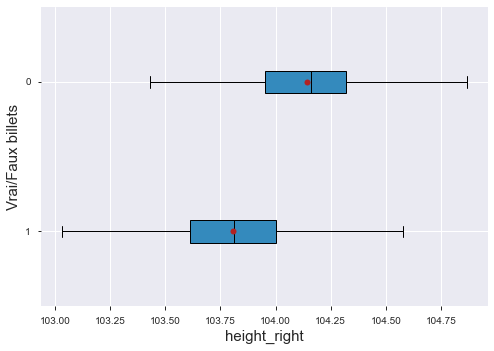

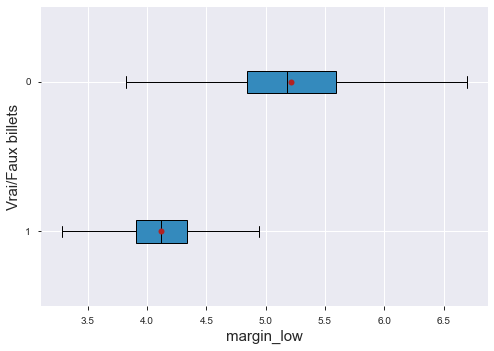

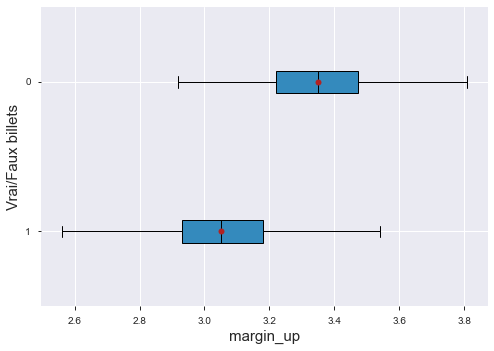

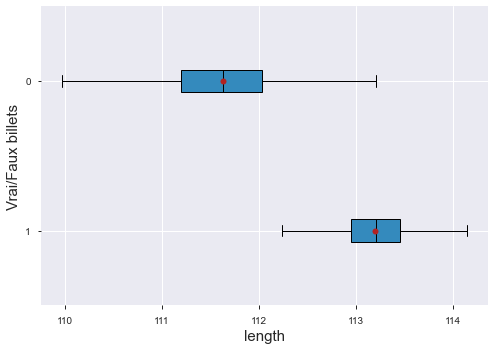

In [41]:
l=['diagonal','height_left','height_right' ,'margin_low' ,'margin_up' ,'length']
for i in l :
    box(i)

# ACP

In [42]:
scaler=StandardScaler()
billets_=scaler.fit_transform(billets.iloc[:,1:7])

In [43]:
pca=PCA()
pca.fit(billets_)

PCA()

In [44]:
coord = pca.fit_transform(billets_)

In [45]:
print(pca.n_components_)

6


In [46]:
print(pca.explained_variance_ratio_)

[0.43288253 0.16956616 0.13025062 0.11824871 0.09602704 0.05302493]


In [47]:
#valeur corrigée
eigval = (1500-1)/1500*pca.explained_variance_
print(eigval)

[2.5972952  1.01739695 0.78150375 0.70949228 0.57616222 0.3181496 ]


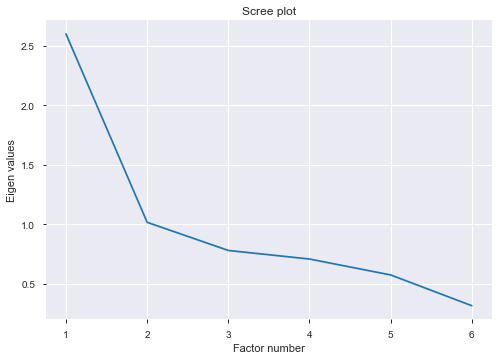

In [48]:
plt.plot(np.arange(1,6+1),eigval)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()

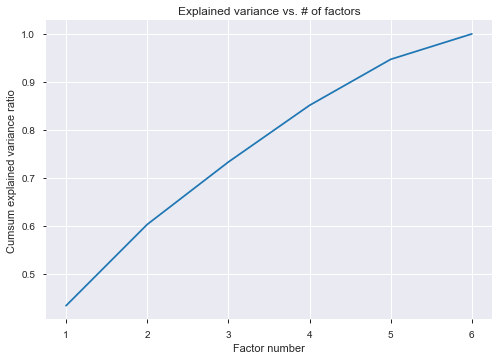

In [49]:
plt.plot(np.arange(1,6+1),np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

In [50]:
print(pca.components_)

[[-0.08469767  0.33063448  0.39355544  0.50769282  0.4394146  -0.52705225]
 [ 0.94130387  0.30752844  0.10833184 -0.07243963 -0.00495445  0.04863598]
 [-0.28784296  0.88504887 -0.16356327 -0.10904608 -0.27011168  0.14909938]
 [-0.10196124 -0.04924399  0.86656155 -0.08927108 -0.44404699  0.17636033]
 [-0.11599182  0.10165163  0.23599848 -0.56408757  0.71198772  0.30886283]
 [ 0.0083408   0.00613019  0.00109087  0.6316212   0.17270117  0.75572523]]


In [51]:
sqrt_eigval = np.sqrt(eigval)

In [52]:
#corrélation des variables avec les axes
corvar = np.zeros((6,6))
for k in range(6):
   corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
#afficher la matrice des corrélations variables x facteurs
print(corvar)

[[-1.36499839e-01  9.49456472e-01 -2.54460950e-01 -8.58833422e-02
  -8.80439982e-02  4.70460853e-03]
 [ 5.32854693e-01  3.10191930e-01  7.82407102e-01 -4.14788872e-02
   7.71590239e-02  3.45772049e-03]
 [ 6.34258902e-01  1.09270097e-01 -1.44594344e-01  7.29916618e-01
   1.79135475e-01  6.15302694e-04]
 [ 8.18204143e-01 -7.30670311e-02 -9.63996768e-02 -7.51942501e-02
  -4.28172648e-01  3.56264369e-01]
 [ 7.08166115e-01 -4.99736101e-03 -2.38786016e-01 -3.74026840e-01
   5.40436777e-01  9.74116638e-02]
 [-8.49404054e-01  4.90572103e-02  1.31807877e-01  1.48550709e-01
   2.34443416e-01  4.26264939e-01]]


In [53]:
df1=pd.DataFrame({'id':billets.iloc[:,1:7].columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]})
df1

id     COR_1     COR_2
0      diagonal -0.136500  0.949456
1   height_left  0.532855  0.310192
2  height_right  0.634259  0.109270
3    margin_low  0.818204 -0.073067
4     margin_up  0.708166 -0.004997
5        length -0.849404  0.049057

La variable diagonal contribue le plus et positivement à l'axe 2 (coefficient de corrélation de 0.95)

Les variables margin_low et margin_up contribuent le plus et positivement à l'axe 1 (coefficient de corrélation de,    respectivement, 0.82 et 0.71). De plus, elles sont bien corrélées (r = 0.43)

La variable lenght contribue négativement à l'axe 1 (coefficient de corrélation de -0.84).

Les variables lenght et margin_low sont assez bien corrélées négativement (r = -0.67).

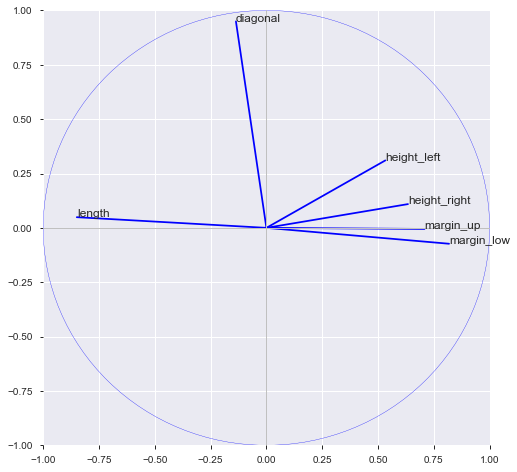

In [54]:
#cercle des corrélations
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
#affichage des étiquettes (noms des variables)
for j in range(6):
   plt.annotate(billets.iloc[:,1:7].columns[j],(corvar[j,0],corvar[j,1]),size=12)
   plt.plot([0, corvar[j,0]], [0, corvar[j,1]],color='Blue')
#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)
#affichage
plt.show()

La variable diagonal contribue fortement (et positivement) à l'axe 2

Les variables margin_low et margin_up contribuent le plus et positivement à l'axe 1.

Les variables height_left et height_right contribuent positivement à l'axe 1.

La variable lenght contribue négativement à l'axe 1.

In [55]:
df=pd.concat([billets.reset_index(drop=True),pd.DataFrame(coord)],axis=1)

In [56]:
df.columns.values[-6:]=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6']

In [57]:
df['billet']=df['is_genuine'].map({1:'Vrai_billet',0:'Faux_billet'})

In [58]:
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0              1    171.81       104.86        104.95        4.52       2.89   
1              1    171.46       103.36        103.66        3.77       2.99   
2              1    172.69       104.48        103.50        4.40       2.94   
3              1    171.36       103.91        103.94        3.62       3.01   
4              1    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495           0    171.75       104.38        104.17        4.42       3.09   
1496           0    172.19       104.63        104.44        5.27       3.37   
1497           0    171.80       104.01        104.12        5.51       3.36   
1498           0    172.06       104.28        104.06        5.17       3.46   
1499           0    171.47       104.15        103.82        4.63       3.37   

      length      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0     112.83  1.644135  0.747843  2.402517  3.180852  0.303985 -0.012247   
1     113.09 -2.019910 -2.207492 -1.001864  0.072937  0.033335 -0.475503   
2     113.16 -0.969864  2.620492  1.195364 -0.923627 -0.837749  0.207343   
3     113.51 -1.377462 -1.818370  0.651110  0.828155  0.799563 -0.230997   
4     112.54  0.148712 -0.566722  0.854043 -1.787713  1.177883 -0.302581   
...      ...       ...       ...       ...       ...       ...       ...   
1495  111.28  1.426243 -0.269650  0.950476  0.520402 -0.250396 -1.315709   
1496  110.97  3.279280  1.317912  0.618890  0.336730 -0.113635 -0.543337   
1497  111.95  1.889684 -0.600282 -0.545922 -0.098042 -0.296977  0.503562   
1498  112.25  1.789783  0.511230  0.028104 -0.474018  0.356655  0.524719   
1499  112.07  1.042159 -1.471302  0.484440 -0.685186  0.484520 -0.235112   

           billet  
0     Vrai_billet  
1     Vrai_billet  
2     Vrai_billet  
3     Vrai_billet  
4     Vrai_billet  
...           ...  
1495  Faux_billet  
1496  Faux_billet  
1497  Faux_billet  
1498  Faux_billet  
1499  Faux_billet  

[1500 rows x 14 columns]

In [59]:
df1=df.reset_index()

In [60]:
df1=df1.rename(columns = {'index': 'id_billet'})

In [61]:
figure = px.scatter(df1, x="PCA1", y="PCA2", color="billet",hover_data=['id_billet'])
figure.show()

L'ACP identifie bien les billets en 2 groupes (les vrais et les faux). On peut voir que quelques points se situent entre les deux groupes. Ces point pourraient poser problème plus tard.

# K-Means

In [62]:
msk = np.random.rand(len(billets)) < 0.6

billets_train = billets[msk]

billets_test = billets[~msk]

In [63]:
yTrain = billets_train.iloc[:,0]

XTrain = billets_train.iloc[:,1:7]

print(yTrain.value_counts())

1    610
0    305
Name: is_genuine, dtype: int64


In [64]:
yTest = billets_test.iloc[:,0]

XTest = billets_test.iloc[:,1:7]

print(yTest.value_counts())

1    390
0    195
Name: is_genuine, dtype: int64


## Méthode des K-Means sur les données d'entrainement

In [65]:
billets_std=scaler.fit_transform(XTrain)

In [66]:
pca.fit(billets_std)

PCA()

In [67]:
print(pca.n_components_)

6


In [68]:
scores_pca=pca.transform(billets_std)

In [69]:
scores_pca

array([[-2.03499696, -1.96594583, -1.47647626,  0.16834707, -0.21591804,
        -0.53014798],
       [ 0.17814768,  1.23682898,  0.25605104, -0.54263281, -0.24988194,
         0.30436192],
       [-1.16714578, -0.23483698, -0.59596909,  1.04124556,  0.28943476,
        -0.31435696],
       ...,
       [ 1.87938016, -0.540423  , -0.67446396, -0.18193059,  0.2363655 ,
         0.46870842],
       [ 1.78730816,  0.43481873,  0.19248108, -0.39545822, -0.40234312,
         0.54297381],
       [ 1.00939093, -1.59851336,  0.31598615, -0.40629018, -0.59045015,
        -0.2005027 ]])

In [70]:
kmeans_pca=KMeans(n_clusters=2,init='k-means++',random_state=100).fit(billets_std)

In [71]:
billets_train

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1              1    171.46       103.36        103.66        3.77       2.99   
6              1    172.34       104.18        103.85        4.58       3.26   
7              1    171.88       103.76        104.08        3.98       2.92   
8              1    172.47       103.92        103.67        4.00       3.25   
9              1    172.47       104.07        104.02        4.04       3.25   
...          ...       ...          ...           ...         ...        ...   
1495           0    171.75       104.38        104.17        4.42       3.09   
1496           0    172.19       104.63        104.44        5.27       3.37   
1497           0    171.80       104.01        104.12        5.51       3.36   
1498           0    172.06       104.28        104.06        5.17       3.46   
1499           0    171.47       104.15        103.82        4.63       3.37   

      length  
1     113.09  
6     112.81  
7     113.08  
8     112.85  
9     113.45  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[915 rows x 7 columns]

In [72]:
df_clus_pca_kmeans=pd.concat([billets_train.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)

In [73]:
df_clus_pca_kmeans.columns.values[-6:]=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6']

In [74]:
df_clus_pca_kmeans['Clusters Kmeans_pca']=kmeans_pca.labels_

In [75]:
df_clus_pca_kmeans

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0             1    171.46       103.36        103.66        3.77       2.99   
1             1    172.34       104.18        103.85        4.58       3.26   
2             1    171.88       103.76        104.08        3.98       2.92   
3             1    172.47       103.92        103.67        4.00       3.25   
4             1    172.47       104.07        104.02        4.04       3.25   
..          ...       ...          ...           ...         ...        ...   
910           0    171.75       104.38        104.17        4.42       3.09   
911           0    172.19       104.63        104.44        5.27       3.37   
912           0    171.80       104.01        104.12        5.51       3.36   
913           0    172.06       104.28        104.06        5.17       3.46   
914           0    171.47       104.15        103.82        4.63       3.37   

     length      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0    113.09 -2.034997 -1.965946 -1.476476  0.168347 -0.215918 -0.530148   
1    112.81  0.178148  1.236829  0.256051 -0.542633 -0.249882  0.304362   
2    113.08 -1.167146 -0.234837 -0.595969  1.041246  0.289435 -0.314357   
3    112.85 -0.824096  1.489416 -0.348800 -0.872606 -0.665835 -0.262931   
4    113.45 -0.574540  1.787358  0.017524  0.224692 -0.790126  0.363967   
..      ...       ...       ...       ...       ...       ...       ...   
910  111.28  1.389995 -0.446046  0.894979  0.547835  0.485455 -1.263878   
911  110.97  3.273634  1.137052  0.913326  0.277221  0.346356 -0.496217   
912  111.95  1.879380 -0.540423 -0.674464 -0.181931  0.236365  0.468708   
913  112.25  1.787308  0.434819  0.192481 -0.395458 -0.402343  0.542974   
914  112.07  1.009391 -1.598513  0.315986 -0.406290 -0.590450 -0.200503   

     Clusters Kmeans_pca  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
..                   ...  
910                    1  
911                    1  
912                    1  
913                    1  
914                    1  

[915 rows x 14 columns]

In [76]:
if df_clus_pca_kmeans[df_clus_pca_kmeans['Clusters Kmeans_pca']==0].shape[0] < df_clus_pca_kmeans[df_clus_pca_kmeans['Clusters Kmeans_pca']==1].shape[0]:
      df_clus_pca_kmeans['Clusters']=df_clus_pca_kmeans['Clusters Kmeans_pca'].map({1:'Vrai_billet',0:'Faux_billet'})
else :
      df_clus_pca_kmeans['Clusters']=df_clus_pca_kmeans['Clusters Kmeans_pca'].map({0:'Vrai_billet',1:'Faux_billet'})

In [77]:
df_clus_pca_kmeans['billets']=df_clus_pca_kmeans['is_genuine'].map({1:'Vrai_billet',0:'Faux_billet'})

In [78]:
df_clus_pca_kmeans

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0             1    171.46       103.36        103.66        3.77       2.99   
1             1    172.34       104.18        103.85        4.58       3.26   
2             1    171.88       103.76        104.08        3.98       2.92   
3             1    172.47       103.92        103.67        4.00       3.25   
4             1    172.47       104.07        104.02        4.04       3.25   
..          ...       ...          ...           ...         ...        ...   
910           0    171.75       104.38        104.17        4.42       3.09   
911           0    172.19       104.63        104.44        5.27       3.37   
912           0    171.80       104.01        104.12        5.51       3.36   
913           0    172.06       104.28        104.06        5.17       3.46   
914           0    171.47       104.15        103.82        4.63       3.37   

     length      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0    113.09 -2.034997 -1.965946 -1.476476  0.168347 -0.215918 -0.530148   
1    112.81  0.178148  1.236829  0.256051 -0.542633 -0.249882  0.304362   
2    113.08 -1.167146 -0.234837 -0.595969  1.041246  0.289435 -0.314357   
3    112.85 -0.824096  1.489416 -0.348800 -0.872606 -0.665835 -0.262931   
4    113.45 -0.574540  1.787358  0.017524  0.224692 -0.790126  0.363967   
..      ...       ...       ...       ...       ...       ...       ...   
910  111.28  1.389995 -0.446046  0.894979  0.547835  0.485455 -1.263878   
911  110.97  3.273634  1.137052  0.913326  0.277221  0.346356 -0.496217   
912  111.95  1.879380 -0.540423 -0.674464 -0.181931  0.236365  0.468708   
913  112.25  1.787308  0.434819  0.192481 -0.395458 -0.402343  0.542974   
914  112.07  1.009391 -1.598513  0.315986 -0.406290 -0.590450 -0.200503   

     Clusters Kmeans_pca     Clusters      billets  
0                      0  Vrai_billet  Vrai_billet  
1                      0  Vrai_billet  Vrai_billet  
2                      0  Vrai_billet  Vrai_billet  
3                      0  Vrai_billet  Vrai_billet  
4                      0  Vrai_billet  Vrai_billet  
..                   ...          ...          ...  
910                    1  Faux_billet  Faux_billet  
911                    1  Faux_billet  Faux_billet  
912                    1  Faux_billet  Faux_billet  
913                    1  Faux_billet  Faux_billet  
914                    1  Faux_billet  Faux_billet  

[915 rows x 16 columns]

## Représentations des billets dans le plan (Train)

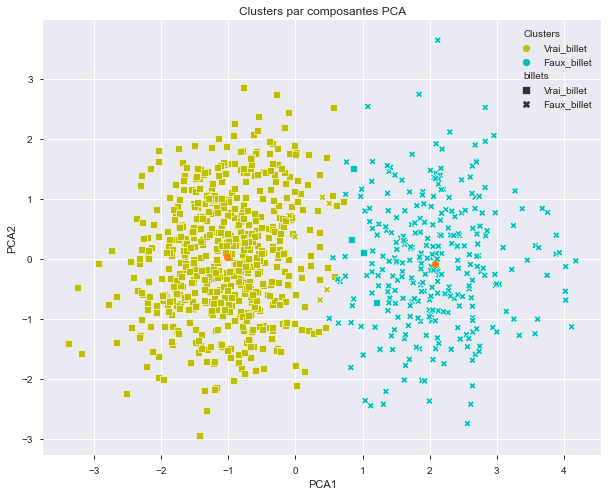

In [79]:
markers = {'Vrai_billet': "s", 'Faux_billet': "X"}
x_axis=df_clus_pca_kmeans['PCA1']
y_axis=df_clus_pca_kmeans['PCA2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_clus_pca_kmeans['Clusters'],style=df_clus_pca_kmeans['billets'],palette=['y','c'],markers=markers)
# Affichage des positions des centres de classes
centroids = kmeans_pca.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title('Clusters par composantes PCA')
plt.show()

In [80]:
df_clus_pca_kmeans[['is_genuine','Clusters Kmeans_pca']]

is_genuine  Clusters Kmeans_pca
0             1                    0
1             1                    0
2             1                    0
3             1                    0
4             1                    0
..          ...                  ...
910           0                    1
911           0                    1
912           0                    1
913           0                    1
914           0                    1

[915 rows x 2 columns]

## Matrice de confusion (Train)

In [81]:
Mat_confusion=pd.crosstab(df_clus_pca_kmeans['billets'],df_clus_pca_kmeans['Clusters'])

In [82]:
def confusion_matrix(df):
    sns.heatmap(df, center=0, cmap='RdBu', 
                linewidths=1, annot=True, fmt=".0f", vmin=0, vmax=600)
    plt.title('Matrice de confusion', fontsize = 15, fontweight='bold')
    plt.show()

In [83]:
Mat_confusion

Clusters     Faux_billet  Vrai_billet
billets                              
Faux_billet          299            6
Vrai_billet            4          606

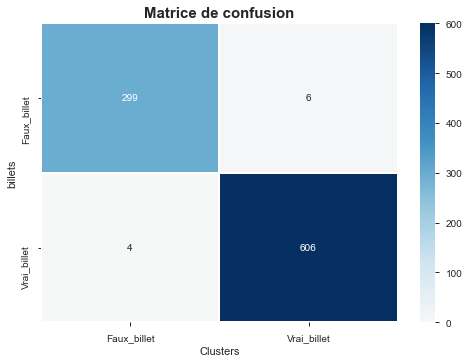

In [84]:
confusion_matrix(Mat_confusion)

Nous remarquons que certains points, à l'interface entre les 2 clusters, peuvent être mal attribués.

## Méthode des K-Means sur les données de test

In [85]:
billets_std_test=scaler.fit_transform(XTest)

In [86]:
pca.fit(billets_std_test)

PCA()

In [87]:
scores_pca_test=pca.transform(billets_std_test)

In [88]:
df_clus_pca_kmeans_test=pd.concat([billets_test.reset_index(drop=True),pd.DataFrame(scores_pca_test)],axis=1)

In [89]:
df_clus_pca_kmeans_test.columns.values[-6:]=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6']

In [90]:
#%%timeit
df_clus_pca_kmeans_test['Clusters Kmeans_pca']=kmeans_pca.predict(billets_std_test)

In [91]:
if df_clus_pca_kmeans_test[df_clus_pca_kmeans_test['Clusters Kmeans_pca']==0].shape[0] < df_clus_pca_kmeans_test[df_clus_pca_kmeans_test['Clusters Kmeans_pca']==1].shape[0]:
      df_clus_pca_kmeans_test['Clusters']=df_clus_pca_kmeans_test['Clusters Kmeans_pca'].map({1:'Vrai_billet',0:'Faux_billet'})
else :
      df_clus_pca_kmeans_test['Clusters']=df_clus_pca_kmeans_test['Clusters Kmeans_pca'].map({0:'Vrai_billet',1:'Faux_billet'})

In [92]:
df_clus_pca_kmeans_test['billets']=df_clus_pca_kmeans_test['is_genuine'].map({1:'Vrai_billet',0:'Faux_billet'})

In [93]:
df_clus_pca_kmeans_test

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0             1    171.81       104.86        104.95        4.52       2.89   
1             1    172.69       104.48        103.50        4.40       2.94   
2             1    171.36       103.91        103.94        3.62       3.01   
3             1    171.73       104.28        103.46        4.04       3.48   
4             1    172.17       103.74        104.08        4.42       2.95   
..          ...       ...          ...           ...         ...        ...   
580           0    172.17       104.33        104.53        5.06       3.71   
581           0    172.08       104.16        104.58        4.79       3.72   
582           0    172.11       104.14        104.15        4.84       3.28   
583           0    171.79       104.18        104.54        5.13       3.51   
584           0    171.57       104.14        104.14        5.41       3.23   

     length      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0    112.83  1.770373  0.831722  3.639226  0.611142  1.265426 -0.407849   
1    113.16 -0.913830  2.868385 -0.142843  1.192754 -0.642205  0.174708   
2    113.51 -1.297417 -1.771466  0.816536  0.530491  0.957689 -0.426654   
3    112.54  0.170297 -0.305652 -1.576038  1.416091  1.009678 -0.484662   
4    112.81 -0.689158  0.285894  0.567138 -1.016821 -0.605292  0.028050   
..      ...       ...       ...       ...       ...       ...       ...   
580  111.75  3.005458  0.943586 -0.406842 -0.980026  1.315823  0.081744   
581  111.04  3.113298  0.424015 -0.594091 -1.473943  1.138838 -0.720924   
582  110.98  1.879149  0.514513 -0.257126 -0.515145 -0.518418 -0.932003   
583  112.40  2.300766 -0.338033  0.397395 -0.704647  1.158797  0.525447   
584  111.76  1.971988 -1.076488  0.328536  0.283907 -0.399751  0.149510   

     Clusters Kmeans_pca     Clusters      billets  
0                      1  Faux_billet  Vrai_billet  
1                      0  Vrai_billet  Vrai_billet  
2                      0  Vrai_billet  Vrai_billet  
3                      0  Vrai_billet  Vrai_billet  
4                      0  Vrai_billet  Vrai_billet  
..                   ...          ...          ...  
580                    1  Faux_billet  Faux_billet  
581                    1  Faux_billet  Faux_billet  
582                    1  Faux_billet  Faux_billet  
583                    1  Faux_billet  Faux_billet  
584                    1  Faux_billet  Faux_billet  

[585 rows x 16 columns]

 ## Représentations des billets dans le plan (Test)

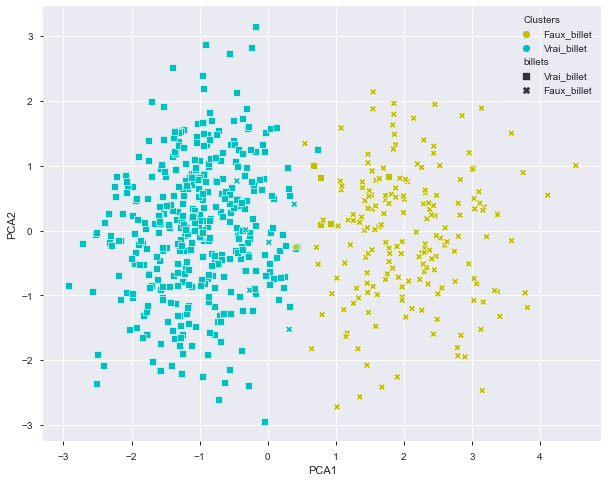

In [94]:
markers = {'Vrai_billet': "s", 'Faux_billet': "X"}
x_axis=df_clus_pca_kmeans_test['PCA1']
y_axis=df_clus_pca_kmeans_test['PCA2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_clus_pca_kmeans_test['Clusters'],style=df_clus_pca_kmeans_test['billets'],palette=['y','c'],markers=markers)
plt.show()

## Matrice de confusion (Test)

In [95]:
Mat_confusion_test=pd.crosstab(df_clus_pca_kmeans_test['billets'],df_clus_pca_kmeans_test['Clusters'])

In [96]:
Mat_confusion_test

Clusters     Faux_billet  Vrai_billet
billets                              
Faux_billet          189            6
Vrai_billet            5          385

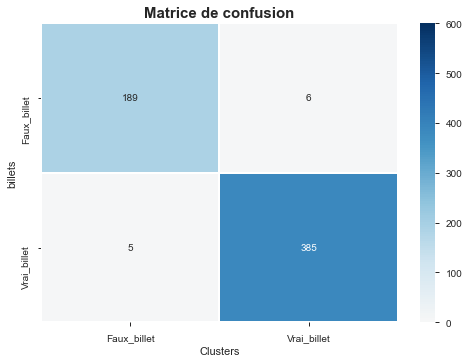

In [97]:
confusion_matrix(Mat_confusion_test)

Nous remarquons que certains points, à l'interface entre les 2 clusters, peuvent être mal attribués.

In [98]:
Precision_test=Mat_confusion_test['Vrai_billet'][1]/(Mat_confusion_test['Vrai_billet'][1]+Mat_confusion_test['Faux_billet'][1])
print(f'La précision du modèle est de {Precision_test}' )

La précision du modèle est de 0.9871794871794872


In [99]:
Recall_test=Mat_confusion_test['Vrai_billet'][1]/(Mat_confusion_test['Vrai_billet'][1]+Mat_confusion_test['Vrai_billet'][0])
print(f'Le rappel du modèle est de {Recall_test}' )

Le rappel du modèle est de 0.9846547314578005


In [100]:
F1_score_test=(2*(Precision_test*Recall_test))/(Precision_test+Recall_test)
print(f'Le score F1 du modèle est de {F1_score_test}' )

Le score F1 du modèle est de 0.9859154929577464


# Régression logistique

In [101]:
XTrainBis_ = sm.tools.add_constant(XTrain)

In [102]:
#régression logistique - on passe la cible et les explicatives
lr_ = Logit(endog=yTrain,exog=XTrainBis_)
#lancer les calculs
#algorithme de Newton-Raphson utilisé par défaut
#https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html
res_ = lr_.fit()

Optimization terminated successfully.
         Current function value: 0.027754
         Iterations 13


In [103]:
print(res_.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  915
Model:                          Logit   Df Residuals:                      908
Method:                           MLE   Df Model:                            6
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.9564
Time:                        11:29:21   Log-Likelihood:                -25.395
converged:                       True   LL-Null:                       -582.41
Covariance Type:            nonrobust   LLR p-value:                1.921e-237
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -113.6501    351.453     -0.323      0.746    -802.485     575.185
diagonal         0.5610      1.578      0.355      0.722      -2.532       3.654
height_left     -2.9655      1.598     -1.85

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 1 %, le niveau de test que nous souhaitons.

## Retirez les variables non significatives



On va donc maintenant retirer les variables non significatives. On commence par la moins significative : diagonal, car elle a une p-valeur supérieure à 0.01.

In [104]:
lr1=Logit(endog=yTrain,exog=XTrainBis_[['const','height_left' ,'height_right','margin_up','margin_low','length']])
res1 = lr1.fit()

Optimization terminated successfully.
         Current function value: 0.027823
         Iterations 12


In [105]:
print(res1.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  915
Model:                          Logit   Df Residuals:                      909
Method:                           MLE   Df Model:                            5
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.9563
Time:                        11:29:21   Log-Likelihood:                -25.458
converged:                       True   LL-Null:                       -582.41
Covariance Type:            nonrobust   LLR p-value:                1.302e-238
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -32.2481    262.425     -0.123      0.902    -546.592     482.096
height_left     -2.9222      1.582     -1.847      0.065      -6.023       0.178
height_right    -2.3290      1.509     -1.54

On voit alors que c'est maintenant height_left , avec une p-valeur qui n'est pas significative. On l'enlève donc.

In [106]:
lr2=Logit(endog=yTrain,exog=XTrainBis_[['const','height_right' ,'margin_up','margin_low','length']])
res2 = lr2.fit()

Optimization terminated successfully.
         Current function value: 0.029965
         Iterations 13


In [107]:
print(res2.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  915
Model:                          Logit   Df Residuals:                      910
Method:                           MLE   Df Model:                            4
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.9529
Time:                        11:29:21   Log-Likelihood:                -27.418
converged:                       True   LL-Null:                       -582.41
Covariance Type:            nonrobust   LLR p-value:                5.186e-239
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -346.6230    203.835     -1.701      0.089    -746.131      52.885
height_right    -2.4695      1.523     -1.622      0.105      -5.454       0.515
margin_up       -8.8571      2.620     -3.38

On voit alors que c'est maintenant height_right , avec une p-valeur qui n'est pas significative. On l'enlève donc.

In [108]:
lr3=Logit(endog=yTrain,exog=XTrainBis_[['const','margin_up','margin_low','length']])
res3 = lr3.fit()

Optimization terminated successfully.
         Current function value: 0.031626
         Iterations 12


In [109]:
print(res3.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  915
Model:                          Logit   Df Residuals:                      911
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.9503
Time:                        11:29:21   Log-Likelihood:                -28.938
converged:                       True   LL-Null:                       -582.41
Covariance Type:            nonrobust   LLR p-value:                1.133e-239
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -660.1859    111.708     -5.910      0.000    -879.129    -441.243
margin_up     -9.6509      2.532     -3.811      0.000     -14.614      -4.688
margin_low    -5.7864      1.113     -5.199      0.0

In [110]:
#données X avec la constante
XTrainBis = sm.tools.add_constant(XTrain[['margin_up','margin_low','length']])
#vérifier la structure
print(XTrainBis.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915 entries, 1 to 1499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   const       915 non-null    float64
 1   margin_up   915 non-null    float64
 2   margin_low  915 non-null    float64
 3   length      915 non-null    float64
dtypes: float64(4)
memory usage: 35.7 KB
None


## Régression logistique sur les données d'entrainement

In [111]:
#régression logistique - on passe la cible et les explicatives
lr = Logit(endog=yTrain,exog=XTrainBis)
#lancer les calculs
#algorithme de Newton-Raphson utilisé par défaut
#https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html
res = lr.fit()

Optimization terminated successfully.
         Current function value: 0.031626
         Iterations 12


In [112]:
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  915
Model:                          Logit   Df Residuals:                      911
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.9503
Time:                        11:29:21   Log-Likelihood:                -28.938
converged:                       True   LL-Null:                       -582.41
Covariance Type:            nonrobust   LLR p-value:                1.133e-239
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -660.1859    111.708     -5.910      0.000    -879.129    -441.243
margin_up     -9.6509      2.532     -3.811      0.000     -14.614      -4.688
margin_low    -5.7864      1.113     -5.199      0.0

In [113]:
#calcul de la prédiction sur l'échantillon test
predProbaSm_train = res.predict(XTrainBis)
#à l'évidence nous avons les probabilités d'affectation
print(predProbaSm_train.describe())

count    9.150000e+02
mean     6.666667e-01
std      4.628307e-01
min      1.632771e-12
25%      9.803805e-04
50%      9.979900e-01
75%      9.999288e-01
max      1.000000e+00
dtype: float64


In [114]:
#convertir en prédiction brute
predSm_train = np.where(predProbaSm_train > 0.5, 1, 0)
print(np.unique(predSm_train,return_counts=True))

(array([0, 1]), array([304, 611], dtype=int64))


## Régression logistique sur les données test

In [115]:
XTest_Bis = add_constant(XTest[['margin_up','margin_low','length']])
print(XTest_Bis.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585 entries, 0 to 1494
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   const       585 non-null    float64
 1   margin_up   585 non-null    float64
 2   margin_low  585 non-null    float64
 3   length      585 non-null    float64
dtypes: float64(4)
memory usage: 22.9 KB
None


In [116]:
#calcul de la prédiction sur l'échantillon test
predProbaSm = res.predict(XTest_Bis)
#à l'évidence nous avons les probabilités d'affectation
print(predProbaSm.describe())

count    5.850000e+02
mean     6.686863e-01
std      4.608662e-01
min      1.669743e-10
25%      7.902995e-04
50%      9.983250e-01
75%      9.999421e-01
max      1.000000e+00
dtype: float64


In [117]:
#convertir en prédiction brute
predSm = np.where(predProbaSm > 0.5, 1, 0)
print(np.unique(predSm,return_counts=True))

(array([0, 1]), array([192, 393], dtype=int64))


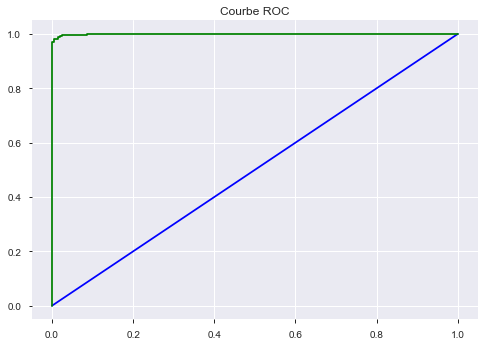

In [118]:
#importer le module metrics
#de la librairie scikit-learn
import sklearn.metrics as metrics
#colonnes pour les courbes ROC
#fpr (false positive rate -- taux de faux positifs) en abscisse
#tpr (true positive rate – taux de vrais positifs) en ordonnée
#pos_label = 1 pour indiquer la modalité cible
fprSm, tprSm, _ = metrics.roc_curve(yTest,predProbaSm,pos_label=1)
#graphique -- construire la diagonale de référence
#cas du modèle qui ne fait pas mieux que l’affectation des probabilités
#au hasard – notre courbe ne doit pas passer en dessous
#plus il s’en écarte vers le haut, mieux c’est
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'b')
#rajouter notre diagramme
plt.plot(fprSm,tprSm,"g")
#titre
plt.title("Courbe ROC")
#faire apparaître le graphique
plt.show()

In [119]:
#valeur de l'AUC
aucSm = metrics.roc_auc_score(yTest,predProbaSm)
print(f"La valeur de l'AUC est de : %.4f" % (aucSm))

La valeur de l'AUC est de : 0.9994


Nous avons un excellent modèle puisque l'AUC est très proche de 1.

## Représentation des billets dans le plan (Train)

In [120]:
scaler_=StandardScaler()
XTrain_std=scaler_.fit_transform(XTrain)

In [121]:
scores_pca_logi_train=pca.transform(XTrain_std)

In [122]:
df_pca_logi_train=pd.concat([billets_train.reset_index(drop=True),pd.DataFrame(scores_pca_logi_train)],axis=1)

In [123]:
df_pca_logi_train.columns.values[-6:]=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6']

In [124]:
df_pca_logi_train

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0             1    171.46       103.36        103.66        3.77       2.99   
1             1    172.34       104.18        103.85        4.58       3.26   
2             1    171.88       103.76        104.08        3.98       2.92   
3             1    172.47       103.92        103.67        4.00       3.25   
4             1    172.47       104.07        104.02        4.04       3.25   
..          ...       ...          ...           ...         ...        ...   
910           0    171.75       104.38        104.17        4.42       3.09   
911           0    172.19       104.63        104.44        5.27       3.37   
912           0    171.80       104.01        104.12        5.51       3.36   
913           0    172.06       104.28        104.06        5.17       3.46   
914           0    171.47       104.15        103.82        4.63       3.37   

     length      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  
0    113.09 -2.065143 -2.381903 -0.310928 -0.550903 -0.294710 -0.341834  
1    112.81  0.134942  1.308108 -0.485868 -0.025698  0.121942  0.309225  
2    113.08 -1.180825 -0.556933  0.871127 -0.707165 -0.073195 -0.265554  
3    112.85 -0.946141  1.355584 -1.117838 -0.536880  0.054234 -0.139756  
4    113.45 -0.678281  1.611811 -0.143380 -0.698753  0.819680  0.305973  
..      ...       ...       ...       ...       ...       ...       ...  
910  111.28  1.467819 -0.178281  0.777599  0.523057 -0.134061 -1.408087  
911  110.97  3.283975  1.377666  0.458589  0.005502  0.052944 -0.625449  
912  111.95  1.866503 -0.654129 -0.272556 -0.386006 -0.341978  0.579420  
913  112.25  1.761812  0.536533 -0.516694  0.022571  0.369775  0.487451  
914  112.07  1.057380 -1.356448 -0.602673  0.791893  0.416067 -0.326253  

[915 rows x 13 columns]

In [125]:
df_pca_logi_train['billets']=df_pca_logi_train['is_genuine'].map({1:'Vrai_billet',0:'Faux_billet'})

In [126]:
df_pca_logi_train['predictions_logi']=pd.DataFrame(predSm_train)

In [127]:
df_pca_logi_train['proba_logi']=pd.DataFrame(predProbaSm_train).reset_index(drop=True)

In [128]:
df_pca_logi_train['pred_logi']=df_pca_logi_train['predictions_logi'].map({1:'Vrai_billet',0:'Faux_billet'})

In [129]:
df_pca_logi_train

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0             1    171.46       103.36        103.66        3.77       2.99   
1             1    172.34       104.18        103.85        4.58       3.26   
2             1    171.88       103.76        104.08        3.98       2.92   
3             1    172.47       103.92        103.67        4.00       3.25   
4             1    172.47       104.07        104.02        4.04       3.25   
..          ...       ...          ...           ...         ...        ...   
910           0    171.75       104.38        104.17        4.42       3.09   
911           0    172.19       104.63        104.44        5.27       3.37   
912           0    171.80       104.01        104.12        5.51       3.36   
913           0    172.06       104.28        104.06        5.17       3.46   
914           0    171.47       104.15        103.82        4.63       3.37   

     length      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0    113.09 -2.065143 -2.381903 -0.310928 -0.550903 -0.294710 -0.341834   
1    112.81  0.134942  1.308108 -0.485868 -0.025698  0.121942  0.309225   
2    113.08 -1.180825 -0.556933  0.871127 -0.707165 -0.073195 -0.265554   
3    112.85 -0.946141  1.355584 -1.117838 -0.536880  0.054234 -0.139756   
4    113.45 -0.678281  1.611811 -0.143380 -0.698753  0.819680  0.305973   
..      ...       ...       ...       ...       ...       ...       ...   
910  111.28  1.467819 -0.178281  0.777599  0.523057 -0.134061 -1.408087   
911  110.97  3.283975  1.377666  0.458589  0.005502  0.052944 -0.625449   
912  111.95  1.866503 -0.654129 -0.272556 -0.386006 -0.341978  0.579420   
913  112.25  1.761812  0.536533 -0.516694  0.022571  0.369775  0.487451   
914  112.07  1.057380 -1.356448 -0.602673  0.791893  0.416067 -0.326253   

         billets  predictions_logi    proba_logi    pred_logi  
0    Vrai_billet                 1  9.999726e-01  Vrai_billet  
1    Vrai_billet                 1  8.062183e-01  Vrai_billet  
2    Vrai_billet                 1  9.999499e-01  Vrai_billet  
3    Vrai_billet                 1  9.941381e-01  Vrai_billet  
4    Vrai_billet                 1  9.998382e-01  Vrai_billet  
..           ...               ...           ...          ...  
910  Faux_billet                 0  3.118649e-03  Faux_billet  
911  Faux_billet                 0  2.122874e-07  Faux_billet  
912  Faux_billet                 0  3.023485e-05  Faux_billet  
913  Faux_billet                 0  5.580020e-04  Faux_billet  
914  Faux_billet                 0  9.513410e-03  Faux_billet  

[915 rows x 17 columns]

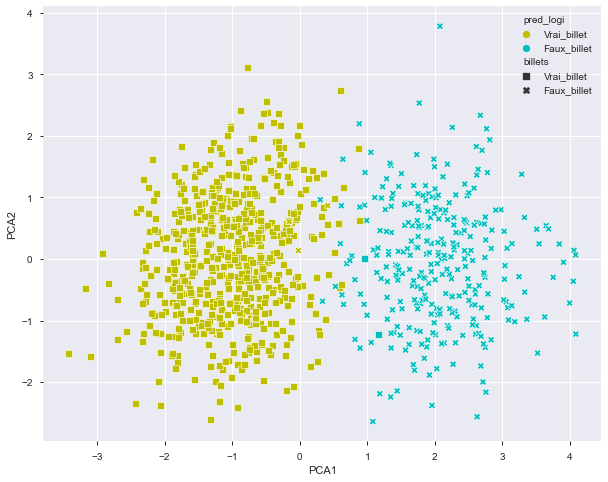

In [130]:
markers = {'Vrai_billet': "s", 'Faux_billet': "X"}
x_axis=df_pca_logi_train['PCA1']
y_axis=df_pca_logi_train['PCA2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_pca_logi_train['pred_logi'],style=df_pca_logi_train['billets'],palette=['y','c'],markers=markers)
plt.show()

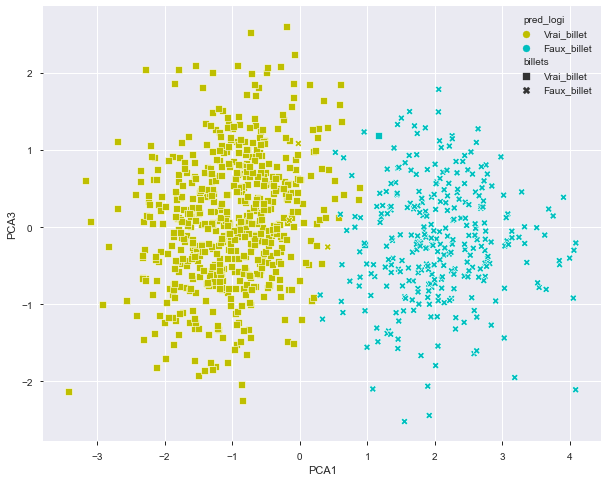

In [131]:
markers = {'Vrai_billet': "s", 'Faux_billet': "X"}
x_axis=df_pca_logi_train['PCA1']
y_axis=df_pca_logi_train['PCA3']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_pca_logi_train['pred_logi'],style=df_pca_logi_train['billets'],palette=['y','c'],markers=markers)
plt.show()

## Matrice de confusion (Train)

In [132]:
Mat_confusion_logi_train=pd.crosstab(df_pca_logi_train['billets'],df_pca_logi_train['pred_logi'])

In [133]:
Mat_confusion_logi_train

pred_logi    Faux_billet  Vrai_billet
billets                              
Faux_billet          302            3
Vrai_billet            2          608

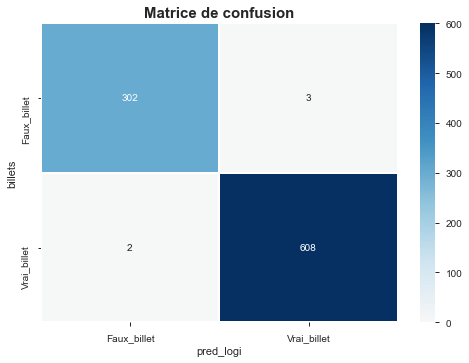

In [134]:
confusion_matrix(Mat_confusion_logi_train)

Nous remarquons que certains points, à l'interface entre les 2 clusters, peuvent être mal attribués.

## Représentation des billets dans le plan (Test)

In [135]:
scaler=StandardScaler()
XTest_std=scaler.fit_transform(XTest)

In [136]:
scores_pca_logi=pca.transform(XTest_std)

In [137]:
scores_pca_logi

array([[ 1.77037313,  0.83172198,  3.63922608,  0.61114237,  1.26542649,
        -0.40784902],
       [-0.91383021,  2.86838457, -0.14284265,  1.19275389, -0.64220514,
         0.17470759],
       [-1.29741739, -1.77146615,  0.81653558,  0.5304908 ,  0.95768912,
        -0.42665369],
       ...,
       [ 1.87914922,  0.51451299, -0.25712648, -0.51514534, -0.51841762,
        -0.93200269],
       [ 2.30076628, -0.33803325,  0.39739549, -0.70464723,  1.15879654,
         0.52544749],
       [ 1.97198764, -1.07648806,  0.32853559,  0.28390745, -0.3997513 ,
         0.14951032]])

In [138]:
df_pca_logi=pd.concat([billets_test.reset_index(drop=True),pd.DataFrame(scores_pca_logi)],axis=1)

In [139]:
df_pca_logi.columns.values[-6:]=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6']

In [140]:
df_pca_logi

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0             1    171.81       104.86        104.95        4.52       2.89   
1             1    172.69       104.48        103.50        4.40       2.94   
2             1    171.36       103.91        103.94        3.62       3.01   
3             1    171.73       104.28        103.46        4.04       3.48   
4             1    172.17       103.74        104.08        4.42       2.95   
..          ...       ...          ...           ...         ...        ...   
580           0    172.17       104.33        104.53        5.06       3.71   
581           0    172.08       104.16        104.58        4.79       3.72   
582           0    172.11       104.14        104.15        4.84       3.28   
583           0    171.79       104.18        104.54        5.13       3.51   
584           0    171.57       104.14        104.14        5.41       3.23   

     length      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  
0    112.83  1.770373  0.831722  3.639226  0.611142  1.265426 -0.407849  
1    113.16 -0.913830  2.868385 -0.142843  1.192754 -0.642205  0.174708  
2    113.51 -1.297417 -1.771466  0.816536  0.530491  0.957689 -0.426654  
3    112.54  0.170297 -0.305652 -1.576038  1.416091  1.009678 -0.484662  
4    112.81 -0.689158  0.285894  0.567138 -1.016821 -0.605292  0.028050  
..      ...       ...       ...       ...       ...       ...       ...  
580  111.75  3.005458  0.943586 -0.406842 -0.980026  1.315823  0.081744  
581  111.04  3.113298  0.424015 -0.594091 -1.473943  1.138838 -0.720924  
582  110.98  1.879149  0.514513 -0.257126 -0.515145 -0.518418 -0.932003  
583  112.40  2.300766 -0.338033  0.397395 -0.704647  1.158797  0.525447  
584  111.76  1.971988 -1.076488  0.328536  0.283907 -0.399751  0.149510  

[585 rows x 13 columns]

In [141]:
df_pca_logi['billets']=df_pca_logi['is_genuine'].map({1:'Vrai_billet',0:'Faux_billet'})

In [142]:
df_pca_logi['predictions_logi']=pd.DataFrame(predSm)

In [143]:
df_pca_logi['proba_logi']=pd.DataFrame(predProbaSm).reset_index(drop=True)

In [144]:
df_pca_logi['pred_logi']=df_pca_logi['predictions_logi'].map({1:'Vrai_billet',0:'Faux_billet'})

In [145]:
df_pca_logi

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0             1    171.81       104.86        104.95        4.52       2.89   
1             1    172.69       104.48        103.50        4.40       2.94   
2             1    171.36       103.91        103.94        3.62       3.01   
3             1    171.73       104.28        103.46        4.04       3.48   
4             1    172.17       103.74        104.08        4.42       2.95   
..          ...       ...          ...           ...         ...        ...   
580           0    172.17       104.33        104.53        5.06       3.71   
581           0    172.08       104.16        104.58        4.79       3.72   
582           0    172.11       104.14        104.15        4.84       3.28   
583           0    171.79       104.18        104.54        5.13       3.51   
584           0    171.57       104.14        104.14        5.41       3.23   

     length      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0    112.83  1.770373  0.831722  3.639226  0.611142  1.265426 -0.407849   
1    113.16 -0.913830  2.868385 -0.142843  1.192754 -0.642205  0.174708   
2    113.51 -1.297417 -1.771466  0.816536  0.530491  0.957689 -0.426654   
3    112.54  0.170297 -0.305652 -1.576038  1.416091  1.009678 -0.484662   
4    112.81 -0.689158  0.285894  0.567138 -1.016821 -0.605292  0.028050   
..      ...       ...       ...       ...       ...       ...       ...   
580  111.75  3.005458  0.943586 -0.406842 -0.980026  1.315823  0.081744   
581  111.04  3.113298  0.424015 -0.594091 -1.473943  1.138838 -0.720924   
582  110.98  1.879149  0.514513 -0.257126 -0.515145 -0.518418 -0.932003   
583  112.40  2.300766 -0.338033  0.397395 -0.704647  1.158797  0.525447   
584  111.76  1.971988 -1.076488  0.328536  0.283907 -0.399751  0.149510   

         billets  predictions_logi    proba_logi    pred_logi  
0    Vrai_billet                 1  9.958114e-01  Vrai_billet  
1    Vrai_billet                 1  9.995855e-01  Vrai_billet  
2    Vrai_billet                 1  9.999990e-01  Vrai_billet  
3    Vrai_billet                 1  6.692669e-01  Vrai_billet  
4    Vrai_billet                 1  9.952423e-01  Vrai_billet  
..           ...               ...           ...          ...  
580  Faux_billet                 0  3.893794e-06  Faux_billet  
581  Faux_billet                 0  1.820227e-07  Faux_billet  
582  Faux_billet                 0  6.492911e-06  Faux_billet  
583  Faux_billet                 0  1.129468e-03  Faux_billet  
584  Faux_billet                 0  5.627679e-05  Faux_billet  

[585 rows x 17 columns]

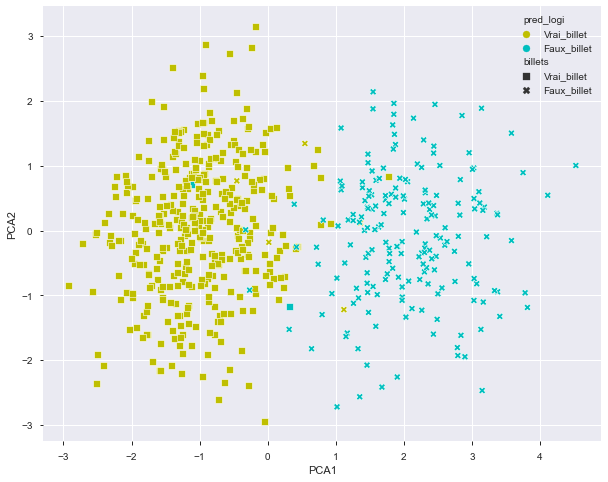

In [146]:
markers = {'Vrai_billet': "s", 'Faux_billet': "X"}
x_axis=df_pca_logi['PCA1']
y_axis=df_pca_logi['PCA2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_pca_logi['pred_logi'],style=df_pca_logi['billets'],palette=['y','c'],markers=markers)
plt.show()

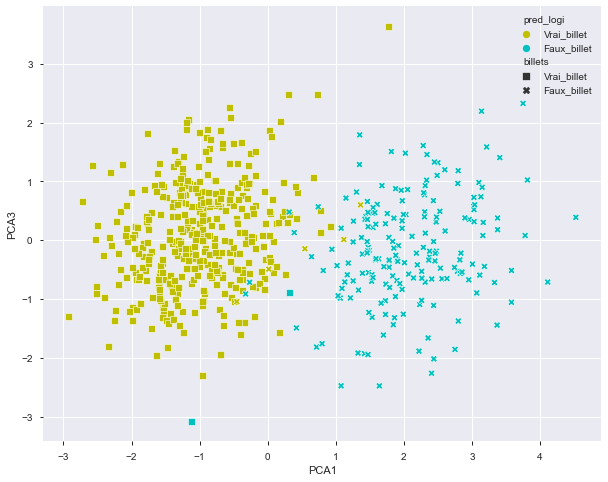

In [147]:
markers = {'Vrai_billet': "s", 'Faux_billet': "X"}
x_axis=df_pca_logi['PCA1']
y_axis=df_pca_logi['PCA3']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_pca_logi['pred_logi'],style=df_pca_logi['billets'],palette=['y','c'],markers=markers)
plt.show()

## Matrice de confusion (Test)

In [148]:
Mat_confusion_logi=pd.crosstab(df_pca_logi['billets'],df_pca_logi['pred_logi'])

In [149]:
Mat_confusion_logi

pred_logi    Faux_billet  Vrai_billet
billets                              
Faux_billet          190            5
Vrai_billet            2          388

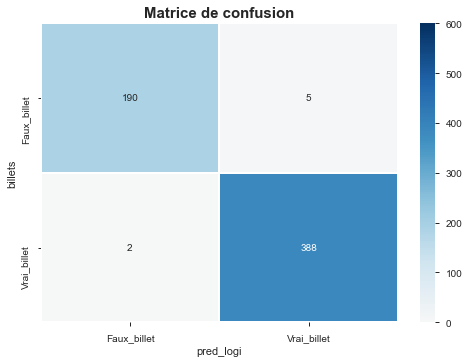

In [150]:
confusion_matrix(Mat_confusion_logi)

Nous remarquons que certains points, à l'interface entre les 2 clusters, peuvent être mal attribués.

In [151]:
Precision_logi=Mat_confusion_logi['Vrai_billet'][1]/(Mat_confusion_logi['Vrai_billet'][1]+Mat_confusion_logi['Faux_billet'][1])
print(f'La précision du modèle est de {Precision_logi}' )

La précision du modèle est de 0.9948717948717949


In [152]:
Recall_logi=Mat_confusion_logi['Vrai_billet'][1]/(Mat_confusion_logi['Vrai_billet'][1]+Mat_confusion_logi['Vrai_billet'][0])
print(f'Le rappel du modèle est de {Recall_logi}' )

Le rappel du modèle est de 0.9872773536895675


In [153]:
F1_score_test=(2*(Precision_logi*Recall_logi))/(Precision_logi+Recall_logi)
print(f'Le score F1 du modèle est de {F1_score_test}' )

Le score F1 du modèle est de 0.9910600255427842


# Algorithmes de detection des faux billets

In [154]:
def reglogipred(X):
    
    X_Test_bis_=add_constant(X[['margin_up','margin_low','length']])
    
    predProbaSm_ = res.predict(X_Test_bis_)
    
    predSm_ = np.where(predProbaSm_ > 0.5, 1, 0)
    
    scaler_1=StandardScaler()
    
    XTest_std_=scaler_1.fit_transform(X.iloc[:,0:6])
    
    scores_pca_logi_=pca.transform(XTest_std_)
    
    df_pca_logi_=pd.concat([X.reset_index(drop=True),pd.DataFrame(scores_pca_logi_)],axis=1)
    
    df_pca_logi_.columns.values[-6:]=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6']
    
    df_pca_logi_['proba_logi']=pd.DataFrame(predProbaSm_).reset_index(drop=True)
    
    df_pca_logi_['predictions_logi']=pd.DataFrame(predSm_)
    
    df_pca_logi_['pred_billets']=df_pca_logi_['predictions_logi'].map({1:'Vrai_billet',0:'Faux_billet'})
    
    print(df_pca_logi_['pred_billets'].value_counts())
    
    fig = px.scatter(df_pca_logi_, x="PCA1", y="PCA2", color="pred_billets", hover_data=['id'])
    fig.show()
    
    return(df_pca_logi_)
    


In [155]:
billets_production=pd.read_csv(r"C:\Users\piard\Downloads\billets_production.csv")

In [156]:
reglogipred(billets_production)

Faux_billet    3
Vrai_billet    2
Name: pred_billets, dtype: int64


diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

       PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  proba_logi  \
0  0.430402 -0.909858 -1.368512  0.389907 -0.848630 -0.369925    0.000010   
1  1.345202 -0.381672 -0.082630 -0.231928 -0.348827  0.884652    0.000007   
2  1.778183  0.546415 -0.113480 -0.034209  0.799903 -0.518405    0.000041   
3 -0.969066  2.221220  1.946273 -0.147709  0.118337  0.104734    0.999036   
4 -2.584721 -1.476105 -0.381650  0.023938  0.279217 -0.101057    0.999969   

   predictions_logi pred_billets  
0                 0  Faux_billet  
1                 0  Faux_billet  
2                 0  Faux_billet  
3                 1  Vrai_billet  
4                 1  Vrai_billet

In [157]:
def Kmeanspred(X):
    
    scores_pca_kM=pca.transform(scaler.fit_transform(X.iloc[:,0:6]))
    
    df=pd.concat([X.reset_index(drop=True),pd.DataFrame(scores_pca_kM)],axis=1)
    
    df.columns.values[-6:]=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6']
    
    df['Clusters_KMeans']=kmeans_pca.predict(scaler.fit_transform(X.iloc[:,0:6]))
    
    
    if df[df['Clusters_KMeans']==0].shape[0] > df[df['Clusters_KMeans']==1].shape[0]:
      df['Clusters']=df['Clusters_KMeans'].map({1:'Vrai_billet',0:'Faux_billet'})
    else:
      df['Clusters']=df['Clusters_KMeans'].map({0:'Vrai_billet',1:'Faux_billet'})
    
    
    df=pd.concat([df,pd.DataFrame((kmeans_pca.transform(scaler.fit_transform(X.iloc[:,0:6]))**2))**0.5],axis=1)
    
    df.columns=['diagonal', 'height_left' ,'height_right' ,'margin_low','margin_up','length',
                'id' ,'PCA1' ,'PCA2' ,'PCA3' ,'PCA4' ,'PCA5' ,'PCA6', 'Clusters_KMeans',
                'Clusters' ,'distance_clus_0','distance_clus_1']
    
    print(df['Clusters'].value_counts())
   
    fig = px.scatter(df, x="PCA1", y="PCA2", color="Clusters", hover_data=['id'])
    fig.show()
    
    return(df)
    

In [158]:
Kmeanspred(billets_production)

Faux_billet    3
Vrai_billet    2
Name: Clusters, dtype: int64


diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

       PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0  0.430402 -0.909858 -1.368512  0.389907 -0.848630 -0.369925   
1  1.345202 -0.381672 -0.082630 -0.231928 -0.348827  0.884652   
2  1.778183  0.546415 -0.113480 -0.034209  0.799903 -0.518405   
3 -0.969066  2.221220  1.946273 -0.147709  0.118337  0.104734   
4 -2.584721 -1.476105 -0.381650  0.023938  0.279217 -0.101057   

   Clusters_KMeans     Clusters  distance_clus_0  distance_clus_1  
0                1  Faux_billet         2.488259         2.398352  
1                1  Faux_billet         2.611690         1.239724  
2                1  Faux_billet         2.997693         1.257579  
3                0  Vrai_billet         2.890127         4.351983  
4                0  Vrai_billet         2.230111         4.890050